# <span style ='color:red'>TP 4 : Modèles probabilistes discriminants pour le Machine Learning</span>

## <span style ='color:red'>Import</span>

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import optim
import numpy as np


## <span style ='color:red'>Exercice 1 : La fonction softmax</span>

### $softmax(x) = \frac{\exp(x_{i})}{\sum_{j =1}^{N}\exp(x_{j})}$ 

==> Pour eviter l'overflow <==

### $softmax(x) = \frac{\exp(x_{i} - max(x))}{\sum_{j =1}^{N}\exp(x_{j} - max(x))}$

In [2]:
def softmax(x):
    x = torch.exp(x - torch.max(x)) / torch.sum(torch.exp(x - torch.max(x)))
    return x


In [3]:
x = torch.tensor([5., 1., 2., -1.])

Test 1 : La fonction softmax devrait retourner le vecteur [0.9341, 0.0171, 0.0465, 0.0023].

In [4]:
### Test 1 ###
print('On applique Softmax à x, on obtient :', softmax(x=x))

On applique Softmax à x, on obtient : tensor([0.9341, 0.0171, 0.0465, 0.0023])


Test 2 :  Cela devrait retourner les valeurs [0.8705, 0.1178, 0.0059, 0.0059].

In [5]:
### Test 2 ###
x2 = torch.tensor([200005., 200003., 200000., 200000.])

Si nous n'évitons pas l'overflow la valeur exp(x2) converge vers Inf et, *in fine*, sort Nan après division.

In [6]:
print('On obtient pour x_test 2 (vec softmax) :', softmax(x=x))

On obtient pour x_test 2 (vec softmax) : tensor([0.9341, 0.0171, 0.0465, 0.0023])


### <span style ='color:red'>**Préambule**: comment utiliser une fonction d’optimisation de gradient avec PyTorch ?</span>

Durant le cours, vous avez vu comment appliquer la descente de gradient stochastique (SGD).
Cette technique, SGD, est la plus simple de descente de gradient, et il en existe d’autres méthodes
d’optimisation: Adam [1], RMSProp [2], etc...
Ils utilisent un ensemble de techniques permettant d’être "meilleur" que SGD, comme l’utilisation
1
du momentum par exemple. Une review est disponible dans [3]. En général, le meilleur d’entre
eux est Adam, que nous allons donc utiliser.
En reprenant l’exemple du cours, voici comment appliquer Adam avec PyTorch [4]:

0
Loss: tensor(0.0100)
theta tensor([5.1999], requires_grad=True) tensor([-2.3000], requires_grad=True) 

50
Loss: tensor(0.0098)
theta tensor([5.1975], requires_grad=True) tensor([-2.2971], requires_grad=True) 

100
Loss: tensor(0.0095)
theta tensor([5.1950], requires_grad=True) tensor([-2.2937], requires_grad=True) 

150
Loss: tensor(0.0093)
theta tensor([5.1926], requires_grad=True) tensor([-2.2904], requires_grad=True) 

200
Loss: tensor(0.0090)
theta tensor([5.1902], requires_grad=True) tensor([-2.2870], requires_grad=True) 

250
Loss: tensor(0.0088)
theta tensor([5.1878], requires_grad=True) tensor([-2.2836], requires_grad=True) 

300
Loss: tensor(0.0086)
theta tensor([5.1854], requires_grad=True) tensor([-2.2802], requires_grad=True) 

350
Loss: tensor(0.0084)
theta tensor([5.1830], requires_grad=True) tensor([-2.2768], requires_grad=True) 

400
Loss: tensor(0.0082)
theta tensor([5.1807], requires_grad=True) tensor([-2.2735], requires_grad=True) 

450
Loss: tensor(0.0080)
theta 

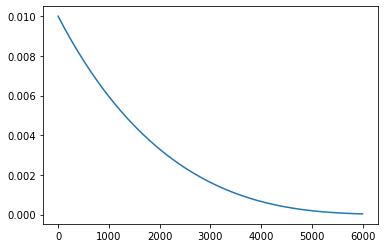

In [7]:
def g(x, a, b):
    return a*x + b

train_set = torch.tensor([(1, 3), (2, 8)])

def L(g, train_set, a, b):
    mse = 0
    for line in train_set:
        x = line[0]
        y = line[1]
        mse += (y - g(x, a, b))**2

    mse /= train_set.shape[0]
    return mse

ak = torch.tensor([5.2], requires_grad=True) # on declare un parametre avec requires_grad = True
bk = torch.tensor([-2.3], requires_grad=True)

alpha = 5*10**(-5)

K = 6000
list_L = torch.zeros(K)
optimizer = optim.Adam([ak, bk], lr=alpha) # on definit un optimizer, avec en argument les parametres lies, et lr son learning rate

for k in range(K):
    optimizer.zero_grad() # on met les gradients a 0
    loss = L(g, train_set, ak, bk)
    loss.backward() # appel de la fonction backward
    optimizer.step() # cette fonction applique l’optimizer

    list_L[k] = loss.item()

    if k % 50 == 0:
        print(k)
        print("Loss:", list_L[k])
        print("theta", ak, bk, "\n")


plt.plot(list_L)
plt.show()

## <span style ='color:red'>Exercice 2 : Classification de chi re avec la régression logistique </span>

Durant cette exercice, vous allez utiliser le très populaire dataset MNIST. Il s’agit du dataset le
plus connu en Computer Vision: il est constitué de 60 000 chi res écrit à la main:

<img src="./MNIST.png" style="width:300;height:300px;" class="center">

Nous nous prenons comme dataset d’entrainement les 50 000 premiers exemples du dataset, et
le reste comme dataset de test.
Votre objectif durant cet exercice est de coder un modèle de régression logistique sur ce dataset.

### <span style='color:red'>2.1 Prise en main du dataset

In [13]:
dataset = torchvision.datasets.MNIST("./", download = True)
train_set_y, train_set_x = dataset.data[:50000], dataset.targets[:50000]
test_set_y, test_set_x = dataset.data[50000:], dataset.targets[50000:]

train_set_y = (train_set_y.view(50000, -1) + 0.0)
mean_train, std_train = torch.mean(train_set_y), torch.std(train_set_y)
train_set_y = (train_set_y - mean_train)/std_train

train_set = []
for i in range(50000):
    train_set.append([train_set_x[i], train_set_y[i]])

test_set_y = (test_set_y.view(10000, -1) + 0.0)
mean_test, std_test = torch.mean(test_set_y), torch.std(test_set_y)
test_set_y = (test_set_y - mean_test)/std_test

test_set = []
for i in range(10000):
    test_set.append([test_set_x[i], test_set_y[i]])

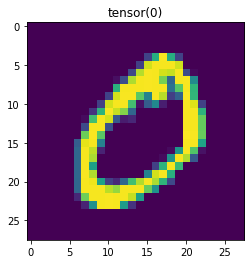

In [14]:
exemple = 1
plt.imshow(train_set[exemple][1].view(28,28))
plt.title(train_set[exemple][0])
plt.show()

### <span style='color:red'>2.2 Votre objectif !

Pour cet exercice, vous devrez coder une régression logistique (n’hésitez pas à utiliser la
fonction softmax de début de TP, ou alors la fonction torch.softmax) ayant pour input le
vecteur d’observations de taille 784, et devant avoir comme output des probabilités que l’image
appartienne à chacune des classes.

Cette régression logistique aura comme paramètres initiaux WLR et bLR chargés de la manière
suivante:

In [15]:
W_lr = torch.load("Tp4_functions/W_lr.pt").requires_grad_(True)
b_lr = torch.load("Tp4_functions/b_lr.pt").requires_grad_(True)

In [16]:
def Logistic(W, y, b):
    return softmax(W @ y + b)

$L_{ce} = -\frac{1}{N}\sum_{x,y}log(f(y)[x])$


avec N le nombre d’exemples, f (y) renvoie les probabilités des différents outputs, et x le vrai label.

In [17]:
#### Fonction de coût ####

def cross_entropy(train_set, W, b):
    Lce = 0
    mse = 0
    for x, y in train_set:
        xpred = Logistic(W,y,b)
        Lce += -torch.log(xpred[x])
        if (torch.argmax(xpred) == x) : mse += 1 
    Lce /= len(train_set)
    mse /= len(train_set)
    return Lce, mse

In [18]:
print('     ------------------------------------------------------------------------------------------------')
print('La valeur de la fonction de coût pour les 100 premiers exemples du train set : ', cross_entropy(train_set[:100], W_lr, b_lr))
print('     ------------------------------------------------------------------------------------------------')


     ------------------------------------------------------------------------------------------------
La valeur de la fonction de coût pour les 100 premiers exemples du train set :  (tensor(2.4652, grad_fn=<DivBackward0>), 0.05)
     ------------------------------------------------------------------------------------------------


In [19]:
indices = torch.randperm(len(train_set))[:256]



In [20]:
l_rate = 5*10**(-5)

nb_ite = 1000

In [21]:
optimizer = optim.Adam([W_lr, b_lr], lr = l_rate)

batch_size == taille du train set prit aléatoirement

Içi le bach size est de 256

In [22]:
list_L = torch.zeros(nb_ite)
for k in range(nb_ite):
    
    indices = torch.randperm(len(train_set))[:256]
    batch = [train_set[i] for i in indices]

    optimizer.zero_grad()
    
    loss, mse = cross_entropy(batch, W_lr, b_lr)
    loss.backward()
    optimizer.step()

    list_L[k] = loss.item()

    if k % 50 == 0:
        print('étape :    ', k)
        print("Loss:    \n", list_L[k])
        print("Score :  \n", mse)
        print("Theta :    ", W_lr, b_lr)
        print('----------------------------------------------------------')



étape :     0
Loss:    
 tensor(2.4799)
Score :  
 0.046875
Theta :     tensor([[ 3.1742e-02, -2.7508e-02, -1.8292e-02,  ...,  2.2725e-02,
          3.2811e-02, -3.5434e-02],
        [ 1.0111e-02, -3.1829e-02, -2.0030e-02,  ...,  8.9828e-03,
          1.7657e-02,  1.4512e-02],
        [ 2.2569e-02,  3.1951e-02,  1.5689e-02,  ...,  3.1024e-02,
          2.3504e-02,  2.6338e-02],
        ...,
        [-1.8780e-02,  1.4564e-02,  3.1911e-02,  ..., -2.9918e-02,
          2.0032e-02,  7.5854e-03],
        [ 2.7105e-02, -5.2234e-03, -3.7834e-03,  ...,  5.3504e-03,
         -1.7578e-02, -2.9025e-02],
        [-6.6355e-03,  3.4121e-02, -3.1593e-05,  ...,  1.1278e-02,
          3.5636e-02, -3.4950e-02]], requires_grad=True) tensor([ 0.0143, -0.0165,  0.0118, -0.0352,  0.0309, -0.0095, -0.0213,  0.0009,
        -0.0192,  0.0092], requires_grad=True)
----------------------------------------------------------
étape :     50
Loss:    
 tensor(2.1011)
Score :  
 0.28515625
Theta :     tensor([[ 0.033

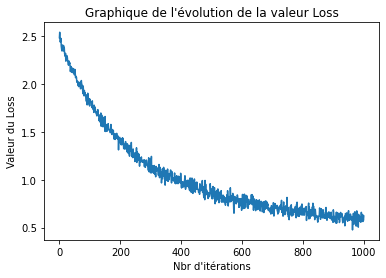

____________________

< == Scores finaux == >
Loss :                tensor(0.6212)
Fin d'entrainement :  85.546875 %


In [23]:
plt.plot(list_L)
plt.title("Graphique de l'évolution de la valeur Loss")
plt.ylabel("Valeur du Loss")
plt.xlabel("Nbr d'itérations")
plt.show()

print('____________________\n')
print('< == Scores finaux == >')
print('Loss :               ', list_L[nb_ite-1])
print("Fin d'entrainement : ", mse*100, "%")


## <span style='color:red'> Exercice 3 : Maximum Entropy Markov Model pour le POS tagging

### <span style='color:red'> 3.1 Nos données

In [74]:
from TP4_functions.load_conll2000 import load_conll2000_glove

In [75]:
path = "TP4_functions/"
Omega_X, train_set, test_set = load_conll2000_glove(path)

Omega_X contient la liste des di érents POS tags, train_set et test_set sont nos données
d’intérêt. Ici, chaque élément d’un jeu de données est formé de deux éléments: [une liste des
POS tags de taille T, un vecteur de taille T × 100]. N’hésitez pas à utiliser la commande:

In [76]:
train_set[0][1][6]

tensor([-0.2780,  0.3023,  0.1873, -0.1258, -0.1285, -1.0955, -0.0345,  0.6472,
        -0.5282, -0.1346, -0.3856,  0.2697,  0.2551, -0.5583,  0.2526, -0.6744,
        -0.1036,  0.1075, -0.1505,  0.0139,  0.4541, -0.7743,  0.1318,  0.9171,
        -0.3521, -0.6056,  0.0522, -0.0693,  0.3083, -0.3359, -0.1404, -0.1164,
        -0.1968, -0.0088,  0.2087,  0.8288,  0.4546,  0.1491, -0.3668,  0.1710,
        -0.6924, -0.7668,  0.2317, -0.2019,  0.0947, -0.2278,  0.2280, -0.7652,
         0.2813, -1.3426,  0.5878, -0.6545,  0.3506,  0.6548,  0.0700, -2.2628,
        -0.7308, -0.3529,  1.8981,  0.7191, -0.2590,  0.5750, -0.5937, -0.2574,
         0.0955,  0.3731, -0.2928,  0.6388,  0.1169, -0.6892,  0.4035, -0.5526,
        -0.8163, -0.4686, -0.0321, -0.3428, -0.4209,  0.1111, -0.4964, -0.1179,
         0.7831, -0.1827, -0.6182, -0.3970, -1.2330, -0.8878,  0.6664,  0.0939,
         0.2445, -0.5144,  0.5246,  0.0851, -0.6263, -0.3201, -0.8261,  0.3662,
         0.4642, -0.0366,  1.0055, -0.13

In [77]:
train_set[0][0]

['NOUN',
 'ADP',
 'DET',
 'NOUN',
 'VERB',
 'ADV',
 'VERB',
 'PART',
 'VERB',
 'DET',
 'ADJ',
 'NOUN',
 'ADP',
 'NOUN',
 'NOUN',
 'ADP',
 'PROPN',
 'PUNCT',
 'ADJ',
 'ADP',
 'NOUN',
 'NOUN',
 'PUNCT',
 'VERB',
 'PART',
 'VERB',
 'DET',
 'ADJ',
 'NOUN',
 'ADP',
 'PROPN',
 'CCONJ',
 'PROPN',
 'PART',
 'ADJ',
 'NOUN',
 'PUNCT']

### <span style='color:red'> 3.2 Votre Objectif !

Votre mission pour ce nouvel exercice est de coder le MEMM avec les fonctions L1 et L2
modélisés par des régressions logistiques. Les valeurs initiales des paramètres devront être
chargés ainsi:

In [78]:
W_lr1 = torch.load("TP4_functions/W_lr1.pt").requires_grad_(True)
b_lr1 = torch.load("TP4_functions/b_lr1.pt").requires_grad_(True)
W_lr2 = torch.load("TP4_functions/W_lr2.pt").requires_grad_(True)
b_lr2 = torch.load("TP4_functions/b_lr2.pt").requires_grad_(True)

In [79]:
W_lr1.shape,  b_lr1.shape, W_lr2.shape,  b_lr2.shape

(torch.Size([15, 100]),
 torch.Size([15]),
 torch.Size([15, 115]),
 torch.Size([15]))

In [80]:
#################################
#### Forward to create alpha ####
#################################
def forw_memm_alpha(y, W_lr1, b_lr1, W_lr2, b_lr2):
    
    nb_words   = y.shape[0]                                                                              
    nb_labels = len(Omega_X)                                                                             
                                                                                                        
    alpha    = torch.zeros(nb_words, nb_labels)                                                          
    alpha[0] = Logistic(W_lr1, y[0], b_lr1)                                                                

    for i in range(nb_words -1):                                                                         
        alpha[i+1] = torch.zeros(nb_labels)              
                                                        
        for j in range(nb_labels):                                                                       
            label_encoded = torch.zeros(nb_labels)    
            #print(label_encoded)                                                   
            label_encoded[j] = 1    
            #print(label_encoded)                                                                                                            
            y_cat = torch.cat((label_encoded, y[i+1]),0) 
            #print(y_t_1_and_x_t)                                        
            alpha[i+1] = alpha[i+1].add(alpha[i,j].item() * Logistic(W_lr2, y_cat, b_lr2))

        #alpha[i+1] = torch.sum(alpha_n, 0)
        #print("\r", alpha, end="")

    return alpha                                                                                                     


In [81]:
def Lossmemm(batch, W_lr1, b_lr1, W_lr2, b_lr2):
    final_lce = 0
    final_score = 0
    for x, y in batch:
        alpha = forw_memm_alpha(y, W_lr1, b_lr1, W_lr2, b_lr2)
        a = [Omega_X.index(l) for l in x]
        lce = 0
        score = 0

        for k in range (len(a)):
            lce -= torch.log(alpha[k][a[k]])
            liste_label_phrase = [torch.argmax(alpha[i]).item() for i in range(len(alpha))]
            if liste_label_phrase[k] == a[k]:
                score += 1
            
        final_lce += lce / len(a)
        final_score += score / len(a)
        
    return(final_score/len(batch), final_lce/len(batch))

In [82]:
f, g = Lossmemm(train_set[:10], W_lr1, b_lr1, W_lr2, b_lr2)

In [84]:
print('la valeur de la fonction de coût avec les paramètres initiaux \npour les dix premiers éléments du train set :', f, g)

la valeur de la fonction de coût avec les paramètres initiaux 
pour les dix premiers éléments du train set : 0.09808791314631136 tensor(2.6976, grad_fn=<DivBackward0>)


In [86]:
iter = 1000
learning_rate = 5*10**(-4)

fct_Loss  = torch.zeros(iter)
liste_score  = np.zeros(iter)

optimizer = optim.Adam([W_lr1, b_lr1, W_lr2, b_lr2], lr = learning_rate)                                                 
                                                                                                        
for k in range(iter):                                                                          

    indices = torch.randperm(len(train_set))[:32]
    batch = [train_set[i] for i in indices]
    
    optimizer.zero_grad()                                                                            
                                                                                                        
    score, loss = Lossmemm(batch, W_lr1, b_lr1, W_lr2, b_lr2)                                             
    loss.backward()                                                                                  
    optimizer.step()                                                                                 
    fct_Loss[k] = loss.item()    
    liste_score[k] = score   

    if (k) % 50 == 0:                                                                                   
        print("----------*******************---------- ") 
        print("Step               : ", k)                 
        print("Valeur du Loss     : ", fct_Loss[k])            
        print("Valeur du Score    : ", liste_score[k])     

----------*******************---------- 
Step               :  0
Valeur du Loss     :  tensor(2.5680)
Valeur du Score    :  0.15352390640294492
----------*******************---------- 
Step               :  50
Valeur du Loss     :  tensor(2.1965)
Valeur du Score    :  0.32571022858967724
----------*******************---------- 
Step               :  100
Valeur du Loss     :  tensor(1.9826)
Valeur du Score    :  0.44646522352797713
----------*******************---------- 
Step               :  150
Valeur du Loss     :  tensor(1.7748)
Valeur du Score    :  0.5367151306855845
----------*******************---------- 
Step               :  200
Valeur du Loss     :  tensor(1.6407)
Valeur du Score    :  0.60197239765919
----------*******************---------- 
Step               :  250
Valeur du Loss     :  tensor(1.5170)
Valeur du Score    :  0.62811414928288
----------*******************---------- 
Step               :  300
Valeur du Loss     :  tensor(1.4156)
Valeur du Score    :  0.634400

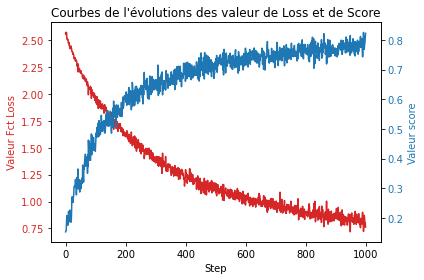

____________________

< == Scores finaux == >
Loss :                tensor(0.7638)
Valeur score (%) :    82.18529822167262


In [90]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Step')
ax1.set_ylabel('Valeur Fct Loss', color=color)
ax1.plot(fct_Loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Valeur score', color=color)  # we already handled the x-label with ax1
ax2.plot(liste_score, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Courbes de l'évolutions des valeur de Loss et de Score")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


print('____________________\n')
print('< == Scores finaux == >')
print('Loss :               ', fct_Loss[999])
print("Valeur score (%) :   ", liste_score[999]*100)
